In [16]:
import pandas as pd
import numpy as np
import yaml
from konlpy.tag import Okt
import json 
import warnings 
import re
warnings.filterwarnings('ignore')

In [6]:
from utils.query_service import QueryService
from model.default import DefaultModel
from utils.modelutil import Word2VecUtil
from utils.validator import RecommendationValidator

In [7]:
# config
with open('configs/database.yaml') as f:
    database_cfg = yaml.load(f, Loader=yaml.FullLoader)
with open('configs/service.yaml') as f:
    service_cfg = yaml.load(f, Loader=yaml.FullLoader)

In [8]:
with open('data/description.json', encoding='utf-8') as f:
    data = json.load(f)
data = {int(k): v for k, v in data.items()}

In [9]:
query_service = QueryService(database_cfg['mysql'])

In [10]:
PRODUCT_BOARD_SQL = """
SELECT id as board_id
, store_id 
, title
, price
, is_soldout
, view 
FROM product_board
"""
product_board = query_service.query_to_pandas_df(PRODUCT_BOARD_SQL)


PRODUCT_SQL = """
SELECT id as product_id
, product_board_id as board_id
, title as option
, price as option_price
, category
, gluten_free_tag
, high_protein_tag
, sugar_free_tag
, vegan_tag
, ketogenic_tag
FROM product
"""
product = query_service.query_to_pandas_df(PRODUCT_SQL)
product = product.groupby('board_id').agg({'option': lambda x: ' '.join(x)})


REVIEW_SQL = """
SELECT board_id 
, badge_taste
, badge_brix
, badge_texture
, rate
, content
FROM review
"""
review = query_service.query_to_pandas_df(REVIEW_SQL)
review = review.drop_duplicates(subset=['board_id', 'content'], keep='first')
review = review.groupby('board_id').agg({'content': lambda x: ' '.join(x)})

In [11]:
df = (product_board
 .merge(product, on='board_id', how='left')
 .merge(review, on='board_id', how='left')
)[['board_id', 'title', 'option', 'content']]

#### 전처리

In [12]:
okt = Okt()
def tokenize(text):
    return ['/'.join(t) for t in okt.pos(text, norm=True, stem=True)]

In [13]:
# 결측치
df = df.fillna('')

In [17]:
# str로 변환
quantity_compiler = re.compile(r'\d+[개입|kg|팩|개|종|입|원|g]+')
for col in ['title', 'option', 'content']:
    df[col] = df[col].astype(str)
    # 소문자로 변환
    df[col] = df[col].apply(lambda x: x.lower())
    # 특수문자 제거
    df[col] = df[col].apply(lambda x: re.sub(r"[^가-힣0-9a-zA-Z\s]", "", x))
    # 숫자 제거
    df[col] = df[col].apply(lambda x: re.sub(quantity_compiler, '', x))
    

In [ ]:
df['description'] = df['title'] + ' ' + df['option'] + ' ' + df['content']

In [ ]:
df['token'] = df['description'].apply(lambda x: okt.morphs(x))

In [ ]:
# 중복 단어 제거 : 나열식의 중복 단어가 노이즈로 인식됨 
df['unique_token'] = df['token'].apply(lambda x: list(set(x)))

In [ ]:
# stopwords 제거
with open('data/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
    stopwords = [x.strip() for x in stopwords]
df['token'] = df['token'].apply(lambda x: [word for word in x if word not in stopwords])

In [ ]:
# description mutation : 
df['representation'] = df['token'].apply(lambda x: ' '.join(x))

In [ ]:
df.set_index('board_id', inplace=True)

In [ ]:
# dict로만들기
data = df['representation'].to_dict()
with open('data/description.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

#### Model Import

In [18]:
default_model = DefaultModel(service_cfg['model']['default'])

In [19]:
word2vec_model_path = "word2vec/korean_word2vec_model.model"  # Update with your actual path
word2vec_model = Word2VecUtil.load_model(word2vec_model_path)

In [20]:
from model.word2vec import Word2Vec
word2vec = Word2Vec(service_cfg['model']['word2vec'], word2vec_model)

#### Recommendation


In [21]:
from collections import defaultdict
rec_result = defaultdict()
model_dict = {'word2vec': word2vec
              , 'default': default_model}
TARGET_MODEL = 'word2vec'
for key in data.keys():
    query_id = key
    try:
        model = model_dict.get(TARGET_MODEL, None)
        items = word2vec.predict(query_id, data)
        RecommendationValidator.valid_topk(items, service_cfg['service']['topk'])
        result = {'items': items, 'recommendation_theme': model.code, 'model_version': model.version}
    except Exception as e:
        model = model_dict.get('default', None)
        items = default_model.predict(query_id, data)
        result = {'items': items, 'recommendation_theme': model.code, 'model_version': model.version}
    finally:
        rec_result[query_id] = result

In [22]:
rows = []
for query, result in rec_result.items():
    key = query
    for i, (k, v) in enumerate(result['items'].items()):
        row = {
            'query_item': key,
            'recommendation_item': k,
            'score': v,
            'rank': i+1,
            'recommendation_theme': result['recommendation_theme'],
            'model_version': result['model_version']
        }
        rows.append(row)
result_df = pd.DataFrame(rows)

In [23]:
result_df['created_at'] = pd.Timestamp.now()

In [24]:
import pickle   
with open('data/rec_result.pickle', 'wb') as f:
    pickle.dump(rec_result, f)

#### Evaluate

In [25]:
# 같은 스토어 상품이 얼마나 있는지
store_df = (result_df
 .merge(product_board[['board_id', 'store_id']], left_on='query_item', right_on='board_id', how='left')
 .rename(columns={'store_id': 'query_store_id'})
 .merge(product_board[['board_id', 'store_id']], left_on='recommendation_item', right_on='board_id', how='left')
 .rename(columns={'store_id': 'recommendation_store_id'})
 [['query_store_id', 'recommendation_store_id']]
)

In [26]:
store_df['same_store_yn'] = store_df['query_store_id'] == store_df['recommendation_store_id']
recommendation_num = store_df.shape[0]
same_store_ratio = round(store_df['same_store_yn'].mean(),2)
print(f'전체 {recommendation_num} 개의 추천 상품 중 찜한 상품과 같은 스토어에 있는 추천의 비율은 {same_store_ratio}')


전체 633 개의 추천 상품 중 찜한 상품과 같은 스토어에 있는 추천의 비율은 0.38


coverage: 80.56872037914692


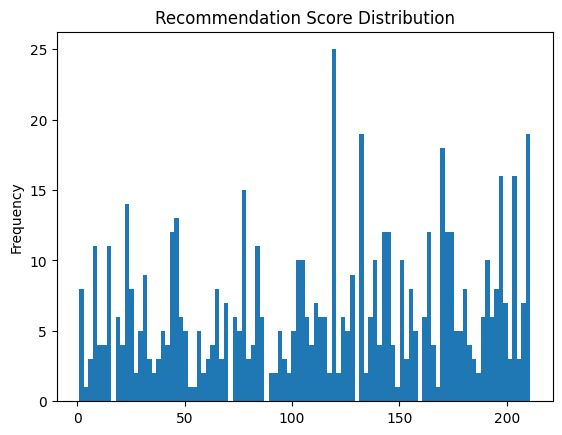

In [27]:
# Coverage
print('coverage:', result_df['recommendation_item'].nunique() / result_df['query_item'].nunique() * 100)
result_df['recommendation_item'].plot(kind='hist', bins=100, title='Recommendation Score Distribution');

In [28]:
result_df

,query_item,recommendation_item,score,rank,recommendation_theme,model_version,created_at
0,1,15,0.947479,1,word2vec,0.0.1,2024-11-03 17:34:18.700163
1,1,78,0.930364,2,word2vec,0.0.1,2024-11-03 17:34:18.700163
2,1,9,0.929003,3,word2vec,0.0.1,2024-11-03 17:34:18.700163
3,2,56,0.950549,1,word2vec,0.0.1,2024-11-03 17:34:18.700163
4,2,65,0.942954,2,word2vec,0.0.1,2024-11-03 17:34:18.700163
...,...,...,...,...,...,...,...
628,210,23,0.937237,2,word2vec,0.0.1,2024-11-03 17:34:18.700163
629,210,171,0.934163,3,word2vec,0.0.1,2024-11-03 17:34:18.700163
630,211,111,0.969866,1,word2vec,0.0.1,2024-11-03 17:34:18.700163
631,211,103,0.948187,2,word2vec,0.0.1,2024-11-03 17:34:18.700163


In [29]:
# 같은 스토어 상품이 얼마나 있는지
title_df = (result_df
 .merge(product_board[['board_id', 'store_id', 'title']], left_on='query_item', right_on='board_id', how='left')
 .rename(columns={'title': 'query_title'
                  , 'store_id': 'query_store_id'})
 .merge(product_board[['board_id', 'store_id', 'title']], left_on='recommendation_item', right_on='board_id', how='left')
 .rename(columns={'title': 'recommendation_title'
                  , 'store_id': 'recommendation_store_id'})
 [['query_item','query_store_id', 'query_title','recommendation_item', 'recommendation_store_id', 'recommendation_title']]
)

In [30]:
# query_item_id의 iterable한 객체 만들기
query_list = list(title_df['query_item'].unique())
query_iter = iter(query_list)

In [31]:
# 반복 
query_item_id = query_iter.__next__()
title_df[title_df['query_item'] == query_item_id][['query_store_id', 'query_title', 'recommendation_store_id', 'recommendation_title']]

,query_store_id,query_title,recommendation_store_id,recommendation_title
0,1,냥빵 파운드 저탄수 대체당 제로 빵 글루텐프리 건강빵 비건,12,수제 비건버터 쌀소금빵
1,1,냥빵 파운드 저탄수 대체당 제로 빵 글루텐프리 건강빵 비건,6,약과 쿠키 영양 간식 건강 디저트
2,1,냥빵 파운드 저탄수 대체당 제로 빵 글루텐프리 건강빵 비건,6,[발효종 순수 통밀빵 2개입 1세트] 저당빵 비건 건강 식사대용 더브레드블루


#### Save

In [32]:
result_df.to_csv('data/rec_result.csv', index=False)